<a href="https://colab.research.google.com/github/kishdubey/sanay/blob/master/sanay/keras_model/sanay_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt  

In [ ]:
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/drive/MyDrive/senti140.csv.zip (Unzipped Files)/senti140.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
PREPROCESSED_DF = "preprocessed.pkl"
WORD2VEC_MODEL = "model.w2v"
SIZE = 300

In [ ]:
df.head()

sentiment  ...                                               text
0          0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  ...  is upset that he can't update his Facebook by ...
2          0  ...  @Kenichan I dived many times for the ball. Man...
3          0  ...    my whole body feels itchy and like its on fire 
4          0  ...  @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]

# Exploring the Data

### Checking for null values

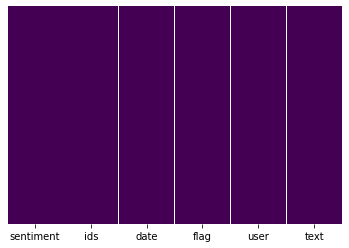

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

As seen above there are not any missing values. Now lets see what the class distribution is like, how many tweets are positive compared to negative?

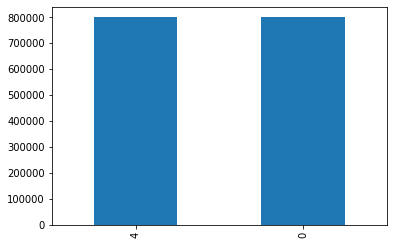

In [ ]:
df.sentiment.value_counts().plot(kind='bar')

The plot shows a balanced dataset with no missing values. Let's preprocess the text to further explore the data.

# Preprocessing Data

## Removing Special Characters, Stop Words, and Lemmatizing Words

In [ ]:
import re
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package brown to /root/nltk_data...
       |   Package brown is already up-to-date!
       | Downloading package brown_tei to /root/nltk_data...
       |   Package brown_tei is already up-to-date!
       | Downloading package cess_cat to /root/nltk_data...
       |   Package cess_cat is already up-to-date!
       | Down

True

Tweets contain a lot of symbols and characters that are not relevant to the meaning of text, removing these can help reduce the size of the data. In addition, text in general contains stop words. Stop words are words that do not add meaning to the text, they are often removed before analyzing text, examples include, he, have, then, but, etc. Furthermore, part of the preprcoessing of text includes stemming/lemmatizing a word. These two techniques essentially convert a word to it's base form. For example running would be turned into run. The main difference between Lemmatizing and Stemming is, that in Lemmatization, the base form will ALWAYS be an actual word, oftentimes when a word is stemmed, the base form does not make sense. This makes Lemmatizing slower in terms of processing while Stemming is much faster.

As these words are necessary for analysis, I will be using Lemmatization trading off a faster processing time.

In [ ]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
STOP_WORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    words = word_tokenize(text) # tokenized words
    
    filter_text = [w for w in words if not w in STOP_WORDS]
    
    for text in filter_text:
        text = lemmatizer.lemmatize(text)
    
    return " ".join(filter_text)

In [ ]:
print(df.text.head()[0])
preprocess(df.text.head()[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


'awww bummer shoulda got david carr third day'

In [ ]:
# apply to all rows
df.text = df.text.apply(lambda x: preprocess(x))
df.head()

sentiment  ...                                               text
0          0  ...       awww bummer shoulda got david carr third day
1          0  ...  upset update facebook texting might cry result...
2          0  ...  dived many times ball managed save 50 rest go ...
3          0  ...                   whole body feels itchy like fire
4          0  ...                                   behaving mad see

[5 rows x 6 columns]

In [ ]:
df.head()

sentiment  ...                                               text
0          0  ...       awww bummer shoulda got david carr third day
1          0  ...  upset update facebook texting might cry result...
2          0  ...  dived many times ball managed save 50 rest go ...
3          0  ...                   whole body feels itchy like fire
4          0  ...                                   behaving mad see

[5 rows x 6 columns]

# Understanding/Modifying the Data 

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

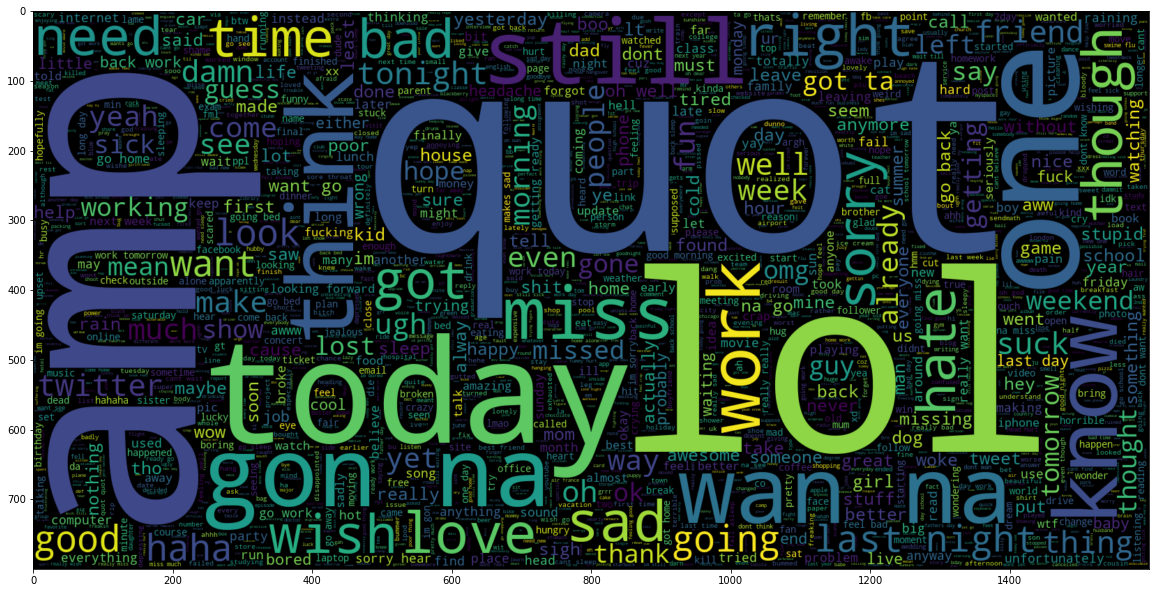

In [ ]:
# negative words
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

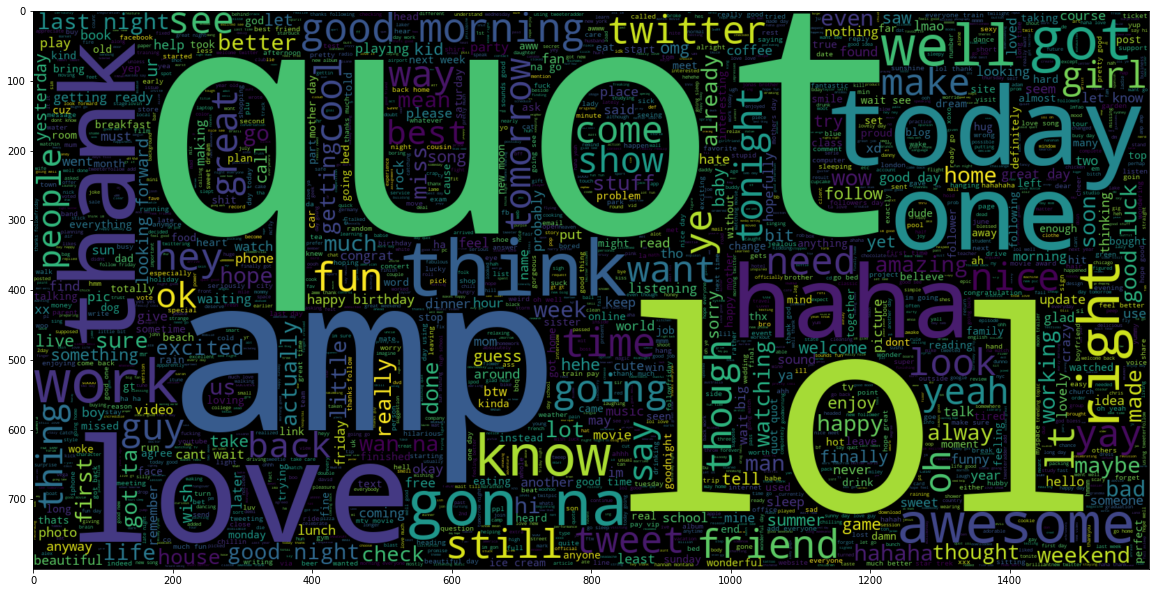

In [ ]:
# positive words
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 4].text))
plt.imshow(wc , interpolation = 'bilinear')

amp, quot, lol are too common for both negative and positive words, these can be considered as stop words for this data.

Lets remove these in order to improve the dataset

In [ ]:
words = set(["amp", "quot", "lol"])
def remove(words, text):
    """
    set -> None
    """
    remove = '|'.join(words)
    regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
    text = regex.sub("", text)
    return " ".join(text.split()) # corrects whitespaces

In [ ]:
text = "gonna wanna one today still amp quot lol"
remove(words, text)

'gonna wanna one today still'

In [ ]:
# apply to df
df.text = df.text.apply(lambda x: remove(words, x))

Let's look at the word cloud again and see the differences.

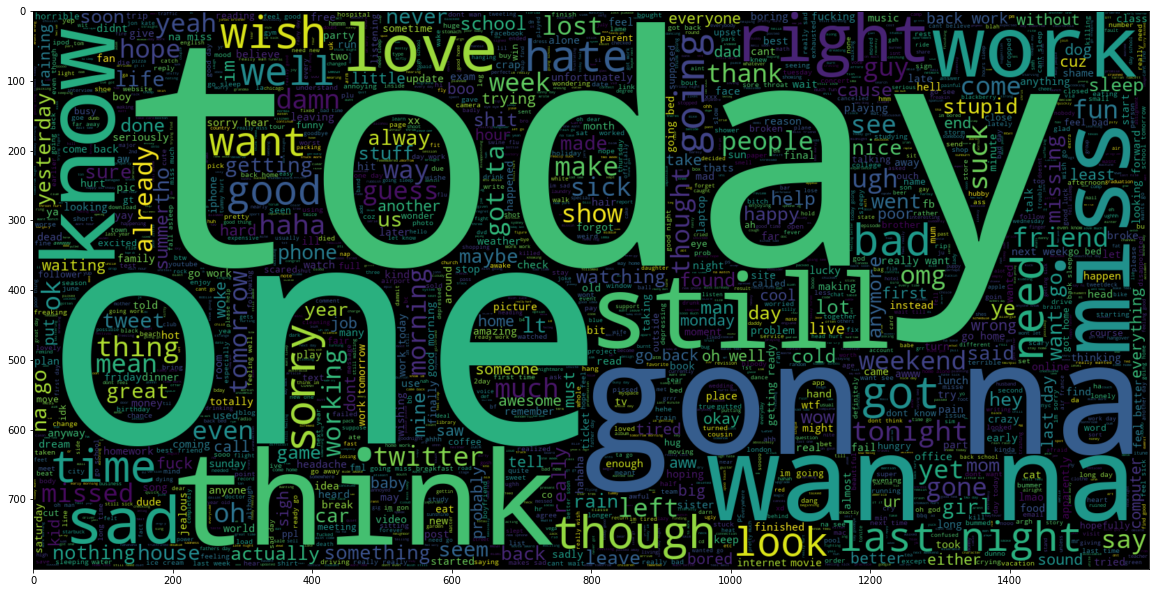

In [ ]:
# negative words
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

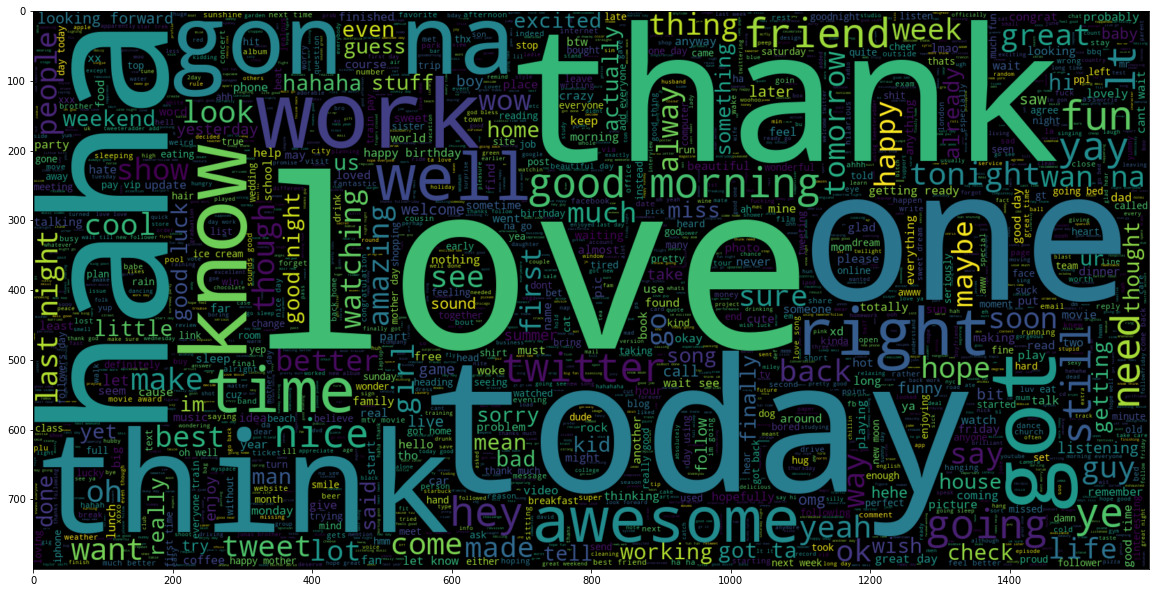

In [ ]:
# positive words
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 4].text))
plt.imshow(wc , interpolation = 'bilinear')

We have done quite some preprocessing. Some text values may actually have been null by now, let's double check and drop these values.

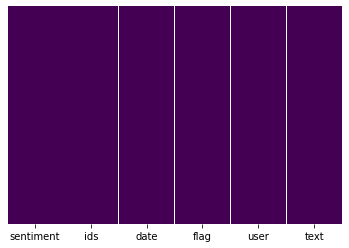

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

All is good, no null values.

In [ ]:
df.to_pickle(PREPROCESSED_DF)

In [ ]:
df = pd.read_pickle(PREPROCESSED_DF)
df.head()

sentiment  ...                                               text
0          0  ...       awww bummer shoulda got david carr third day
1          0  ...  upset update facebook texting might cry result...
2          0  ...  dived many times ball managed save 50 rest go ...
3          0  ...                   whole body feels itchy like fire
4          0  ...                                   behaving mad see

[5 rows x 6 columns]

Lets take a deep dive into the text. Start by analyzing the length of tweets.

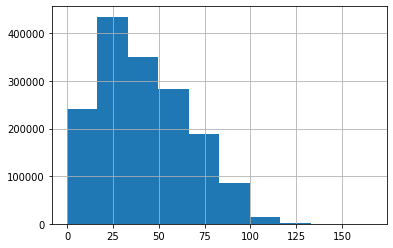

In [ ]:
df['text'].str.len().hist()

In [ ]:
min(df['text'].str.len()), max(df['text'].str.len())

(0, 166)

The Tweet Length range is from 2 to 167 characters, while the majority lay between 2 to 68 characters. This makes sense as tweets are relatively short with a maximum of 280 characters. 

Does this data correlate with messaging data in terms of length? This dataset was chosen for this project as suggested in this research paper, https://www.ijert.org/research/sentiment-analysis-of-chat-application-IJERTV3IS080414.pdf. There is a lack of clean conversational data for sentiment analysis. How similar is messaging data vs. tweets?

# Split train and test

In [ ]:
# removing columns which are not being used
df.drop('ids', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)
df.drop('flag', axis=1, inplace=True)
df.drop('user', axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X, Y = list(df['text']), list(df['sentiment'])

In [ ]:
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 1280000
TEST size: 320000


# Word2Vec

Word2Vec helps create word embeddings, which are capable of capturing context of words in a document through vector representations. Word embedings are vector representations of a particular word. 

In [ ]:
from gensim.models import Word2Vec

In [ ]:
data = [text.split() for text in X_train]

In [ ]:
w2v_model = Word2Vec(data, size=SIZE, workers=5, min_count=5)

In [ ]:
print("Vocabulary Length:", len(w2v_model.wv.vocab))

Vocabulary Length: 48138


In [ ]:
%%time
w2v_model.train(data, total_examples=len(data), epochs=32)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


(264804173, 291868704)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5955735445022583),
 ('loves', 0.5810648202896118),
 ('loved', 0.539211630821228),
 ('amazing', 0.5221854448318481),
 ('adore', 0.4988989531993866),
 ('awesome', 0.4879617989063263),
 ('looove', 0.4753372073173523),
 ('miss', 0.45362910628318787),
 ('lovee', 0.4356134831905365),
 ('loving', 0.43551748991012573)]

In [ ]:
w2v_model.most_similar("hate")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hates', 0.5477817058563232),
 ('sucks', 0.5159456133842468),
 ('stupid', 0.47201213240623474),
 ('suck', 0.4677004814147949),
 ('dislike', 0.46412891149520874),
 ('hating', 0.44268888235092163),
 ('h8', 0.42252403497695923),
 ('ugh', 0.41598081588745117),
 ('annoying', 0.40914186835289),
 ('despise', 0.3835791051387787)]

In [ ]:
w2v_model.save('model.w2v')

In [ ]:
w2v_model = Word2Vec.load('model.w2v')

# Tokenizing Text, Padding Sequences, Embedding Matrix

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

Word Tokenizer -> Getting each word from a sentence

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print("Words: "+str(len(tokenizer.word_index) + 1))

Words: 290411


padding sequences allows so that all inputs have the same length. usually done by adding 0 in front of input until all are same length

In [ ]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SIZE)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SIZE)

In [ ]:
X_train_padded

array([[     0,      0,      0, ...,    709,    116,  24583],
       [     0,      0,      0, ...,    450,    376,  32440],
       [     0,      0,      0, ...,   2044,      4,   5481],
       ...,
       [     0,      0,      0, ...,    659,   4240, 290408],
       [     0,      0,      0, ...,   1772,    475,    954],
       [     0,      0,      0, ...,      9,    500,    266]], dtype=int32)

In [ ]:
vocab_size = len(tokenizer.word_index)
vocab_size

290410

In [ ]:
print('Shape of tensor:', X_train_padded.shape)

Shape of tensor: (1280000, 300)


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Embedding Layer is the first hidden layer in our NN. It is important to have this layer as it makes the training process more computationally efficient and allows for us to visualize realtionships between words in each epoch of training.

In [ ]:
# creating the embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290411, 300)


# Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

Turning labels into machine-readable form

In [ ]:
labels = set(y_train)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)

LabelEncoder()

In [ ]:
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


# Building model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
%%time
model = Sequential()
model.add(Embedding(vocab_size+1, SIZE, weights=[embedding_matrix], input_length=SIZE, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87123300  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,283,801
Trainable params: 160,501
Non-trainable params: 87,123,300
_________________________________________________________________
CPU times: user 1.76 s, sys: 861 ms, total: 2.62 s
Wall time: 6.99 s


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
%%time
history = model.fit(X_train_padded, y_train,
                    batch_size=512,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
2250/2250 [==============================] - 1036s 461ms/step - loss: 0.5001 - accuracy: 0.7530 - val_loss: 0.4651 - val_accuracy: 0.7793
Epoch 2/5
2250/2250 [==============================] - 1032s 459ms/step - loss: 0.4775 - accuracy: 0.7684 - val_loss: 0.4558 - val_accuracy: 0.7850
Epoch 3/5
2250/2250 [==============================] - 1030s 458ms/step - loss: 0.4724 - accuracy: 0.7716 - val_loss: 0.4538 - val_accuracy: 0.7866
Epoch 4/5
2250/2250 [==============================] - 1027s 457ms/step - loss: 0.4689 - accuracy: 0.7736 - val_loss: 0.4502 - val_accuracy: 0.7874
Epoch 5/5
2250/2250 [==============================] - 1026s 456ms/step - loss: 0.4669 - accuracy: 0.7750 - val_loss: 0.4493 - val_accuracy: 0.7880
CPU times: user 1h 42min 46s, sys: 4min 44s, total: 1h 47min 30s
Wall time: 1h 25min 57s


#Evaluating the Model

In [ ]:
%%time
score = model.evaluate(X_test_padded, y_test, batch_size=512)

print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

625/625 [==============================] - 78s 125ms/step - loss: 0.4474 - accuracy: 0.7895

ACCURACY: 0.7895093560218811
LOSS: 0.44735991954803467
CPU times: user 1min 16s, sys: 5.93 s, total: 1min 21s
Wall time: 1min 18s


# Predicting

In [ ]:
def predict(text, include_neutral=True):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SIZE)
    score = model.predict([x_test])[0]
    if(score >=0.4 and score<=0.6):
        label = "Neutral"
    if(score <=0.4):
        label = "Negative"
    if(score >=0.6):
        label = "Positive"

    return {"label" : label,
        "score": float(score)}

In [ ]:
print(predict("I am so happy"))
print(predict("Iam so sad"))
print(predict("I am okay"))

{'label': 'Positive', 'score': 0.8595618009567261}
{'label': 'Negative', 'score': 0.004685783758759499}
{'label': 'Neutral', 'score': 0.5750648379325867}


# Saving the Model

In [ ]:
model.save('/content/drive/MyDrive/model.h5')

In [ ]:
import keras
model = keras.models.load_model('/content/drive/MyDrive/model.h5')